In [ ]:
import os
import shutil
import json
import yaml
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# Define paths 
BASE_DIR = Path(os.getcwd())
COCO_DIR = BASE_DIR / "signs_coco"
IMAGES_DIR = COCO_DIR / "images"
JSON_FILE = COCO_DIR / "result.json"

# Output directories for YOLO format
YOLO_DATA_DIR = BASE_DIR / "yolo_dataset"
TRAIN_IMG_DIR = YOLO_DATA_DIR / "images" / "train"
VAL_IMG_DIR = YOLO_DATA_DIR / "images" / "val"
TRAIN_LBL_DIR = YOLO_DATA_DIR / "labels" / "train"
VAL_LBL_DIR = YOLO_DATA_DIR / "labels" / "val"

for d in [TRAIN_IMG_DIR, VAL_IMG_DIR, TRAIN_LBL_DIR, VAL_LBL_DIR]:
    d.mkdir(parents=True, exist_ok=True)
    
print("Directories created.")


Directories created.


In [ ]:
def convert_coco_to_yolo(json_path, output_labels_dir):
    with open(json_path) as f:
        data = json.load(f)
    
    # Map category IDs to names and create a 0-indexed mapping
    categories = {cat['id']: cat['name'] for cat in data['categories']}
    cat_id_to_yolo_idx = {original_id: idx for idx, original_id in enumerate(categories.keys())}
    yolo_names = [categories[original_id] for original_id in categories.keys()]
    
    img_id_to_anns = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in img_id_to_anns:
            img_id_to_anns[img_id] = []
        img_id_to_anns[img_id].append(ann)
    
    processed_files = []
    
    for img in data['images']:
        img_id = img['id']
        file_name = img['file_name']
        
        if img_id not in img_id_to_anns:
            continue
        
        w_img = img['width']
        h_img = img['height']
        
        label_lines = []
        for ann in img_id_to_anns[img_id]:
            cat_id = ann['category_id']
            bbox = ann['bbox']
            
            x_center = (bbox[0] + bbox[2] / 2) / w_img
            y_center = (bbox[1] + bbox[3] / 2) / h_img
            width = bbox[2] / w_img
            height = bbox[3] / h_img
            
            cls_idx = cat_id_to_yolo_idx[cat_id]
            label_lines.append(f"{cls_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        processed_files.append({
            'file_name': file_name,
            'labels': label_lines
        })
    
    return processed_files, yolo_names

print("Converting annotations...")
files_data, class_names = convert_coco_to_yolo(JSON_FILE, YOLO_DATA_DIR / "labels")
print(f"Converted {len(files_data)} images with annotations.")
print(f"Classes: {class_names}")


Converting annotations...
Converted 602 images with annotations.
Classes: ['Animal', 'Back', 'Blind-Spot Mirror (Convex)', 'Bump', 'Circular', 'Damaged', 'Front', 'Give way', 'Good', 'Heavily Damaged', 'Maximum Height', 'No Entry (One Way)', 'No Parking', 'No Stopping', 'No Through Road (T-sign)', 'No Turn (left/right)', 'No U-turn', 'No Waiting', 'Octagonal', 'Parking', 'Pedestrian Crossing', 'Pole-mounted', 'Priority To/Over Oncoming Vehicles', 'Road Narrows', 'Roadworks', 'Roundabout Ahead', 'Side', 'Speed Limit', 'Square', 'Stop', 'Traffic Light', 'Triangular', 'Turn (left/right)', 'Two Way', 'Two-way traffic', 'Uneven Road', 'Wall-mounted', 'Weathered']


In [ ]:
# Split into training and validation sets
train_files, val_files = train_test_split(files_data, test_size=0.2, random_state=42)

def save_split(split_data, img_dest, lbl_dest):
    for item in split_data:
        src_name = os.path.basename(item['file_name'])
        src_path = IMAGES_DIR / src_name
        
        if not src_path.exists():
            print(f"Warning: Image not found {src_path}")
            continue
        
        shutil.copy(src_path, img_dest / src_name)
        
        txt_name = os.path.splitext(src_name)[0] + ".txt"
        with open(lbl_dest / txt_name, 'w') as f:
            f.write("\n".join(item['labels']))

print("Saving Training set...")
save_split(train_files, TRAIN_IMG_DIR, TRAIN_LBL_DIR)

print("Saving Validation set...")
save_split(val_files, VAL_IMG_DIR, VAL_LBL_DIR)

print("Data preparation complete.")


Saving Training set...
Saving Validation set...
Data preparation complete.


In [11]:
yaml_content = f"""
path: {YOLO_DATA_DIR.absolute()} 
train: images/train
val: images/val

nc: {len(class_names)}
names: {class_names}
"""

with open("dataset.yaml", "w") as f:
    f.write(yaml_content)

print("dataset.yaml created.")


dataset.yaml created.


In [ ]:
model = YOLO("yolov10n.pt")  # yolo v10 nano model

results = model.train(
    data="dataset.yaml",
    epochs=50,      
    imgsz=640,      
    batch=16,       
    device=0,
    name="signs_yolov10n"  
)

print("Training finished!")


New https://pypi.org/project/ultralytics/8.4.9 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.4.8 🚀 Python-3.13.11 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 11867MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=signs_yolov10n3, 


image 1/1 /home/nix/git/CV-Signs/yolo_dataset/images/val/edde4330-IMG_6345.jpeg: 640x480 1 No Entry (One Way), 5.6ms
Speed: 1.6ms preprocess, 5.6ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 480)


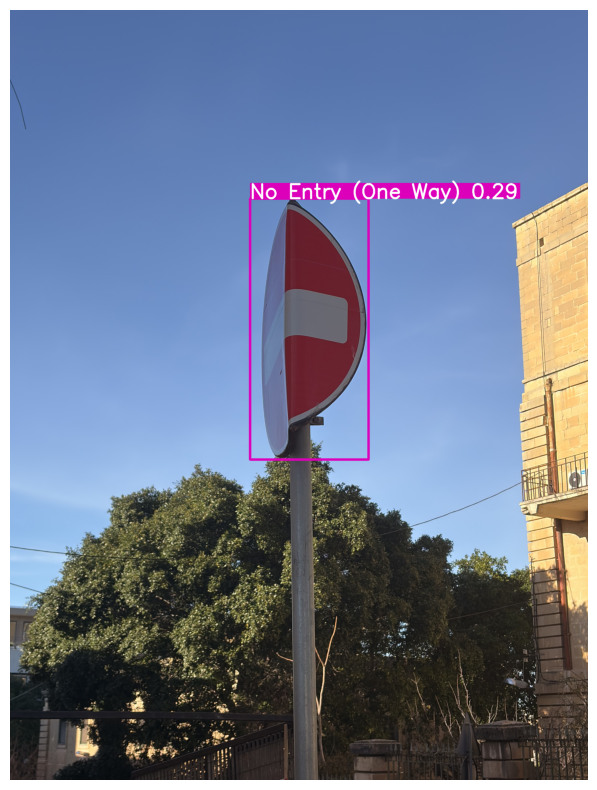

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import random

val_images = list(VAL_IMG_DIR.glob("*.jpg")) + list(VAL_IMG_DIR.glob("*.jpeg"))
test_img = random.choice(val_images)

results = model.predict(test_img, conf=0.25)
res_plotted = results[0].plot()
res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(res_rgb)
plt.axis('off')
plt.show()
